## 1. 라이브러리 설치 및 불러오기  
YOLO 모델을 실행하기 위한 환경을 구성하는 코드입니다.  
필요한 패키지를 설치하고, 이미지 처리 및 데이터 로딩에 필요한 라이브러리를 불러옵니다.

> ✅ 설치 패키지
- `ultralytics`: YOLO 모델 실행 및 학습
- `opencv-python`: 이미지 로딩 및 전처리
- `numpy`, `matplotlib`: 데이터 처리 및 시각화

> ✅ 불러오는 핵심 라이브러리
- `torch`, `torchvision`: 모델 학습 및 데이터 전처리
- `ultralytics.YOLO`: YOLO 모델 로딩
- `cv2`, `numpy`: 이미지 처리 및 수치 계산
- `tqdm`, `matplotlib.pyplot`: 시각화 및 진행 표시

In [45]:
import os
import cv2
import torch
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [46]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## 2. 랜덤 시드 고정

실험의 일관성을 유지하기 위해 `random`, `numpy`, `torch`의 시드를 고정합니다.  

In [47]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_everything()

## 3. 데이터 경로 설정 및 YAML 파일 로드
`data.yaml` 파일을 불러와 학습(train), 검증(val) 데이터의 경로를 설정합니다.

> ✅ 학습 데이터는 모델을 학습시키는 데 사용되며,  
> ✅ 검증 데이터는 학습 중 모델의 성능을 평가하고 과적합 여부를 확인하는 데 사용됩니다.

In [49]:
DATA_YAML_PATH = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/data.yaml"

with open(DATA_YAML_PATH, "r", encoding="utf-8") as f:
    data_yaml = yaml.safe_load(f)

DATASET_PATH = os.path.dirname(DATA_YAML_PATH)
TRAIN_IMAGES = os.path.join(DATASET_PATH, data_yaml["train"].replace("../", ""))
VALID_IMAGES = os.path.join(DATASET_PATH, data_yaml["val"].replace("../", ""))

print(DATASET_PATH)
print(TRAIN_IMAGES)
print(VALID_IMAGES)

C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE
C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images
C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/valid/images


## 4. 데이터셋 클래스 정의 및 로드  
객체 탐지 모델을 위한 이미지 데이터셋을 생성하고 불러오는 과정입니다.  
OpenCV와 glob을 활용하여 이미지를 로드하고, torchvision.transforms를 적용해  
크기 변환 및 텐서 변환을 수행합니다.  
마지막으로 샘플 이미지를 시각화하여 데이터가 올바르게 불러와졌는지 확인합니다.

훈련 데이터 샘플


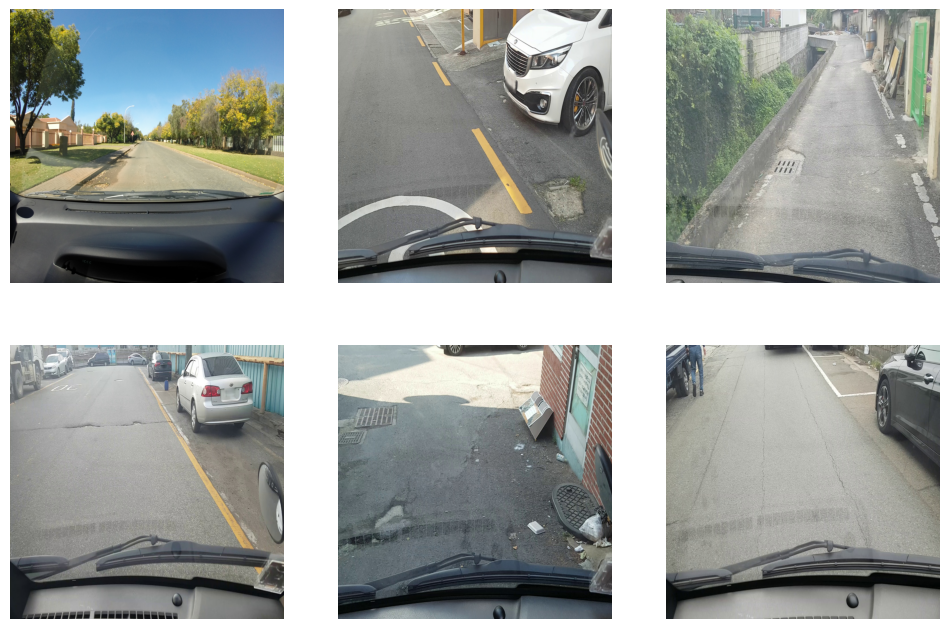

In [50]:
class PotholeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob(os.path.join(image_dir, "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return self.transform(img) if self.transform else img


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

train_loader = DataLoader(PotholeDataset(TRAIN_IMAGES, transform), batch_size=16, shuffle=True)
valid_loader = DataLoader(PotholeDataset(VALID_IMAGES, transform), batch_size=16, shuffle=False)


def show_sample_images(image_loader):
    sample_images = next(iter(image_loader))

    fig, ax = plt.subplots(2, 3, figsize=(12, 8))

    for i, img in enumerate(sample_images[:6]):
        ax[i // 3, i % 3].imshow(img.permute(1, 2, 0).numpy())
        ax[i // 3, i % 3].axis("off")

    plt.show()


print("훈련 데이터 샘플")
show_sample_images(train_loader)

In [7]:
IMAGE_DIR = "C:/Users/User/Downloads/pothole-detection-challenge/train/images"


In [53]:
from glob import glob
import os

IMAGE_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images"
IMAGE_PATHS = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))
print("찾은 이미지 수:", len(IMAGE_PATHS))


찾은 이미지 수: 25713


In [54]:
import os
from glob import glob
import random
import cv2

IMAGE_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images"
IMAGE_PATHS = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))

print("총 이미지 수:", len(IMAGE_PATHS))
print("예시 경로:", IMAGE_PATHS[:5])

# 에러 방지용
if not IMAGE_PATHS:
    raise ValueError("📛 이미지 리스트가 비어 있음! 경로 확인 필요")

# 랜덤 이미지 선택
IMG_PATH = random.choice(IMAGE_PATHS)
LABEL_PATH = IMG_PATH.replace("images", "labels").replace(".jpg", ".txt")

# 이미지 로딩 시도
img = cv2.imread(IMG_PATH)
if img is None:
    raise ValueError(f"📛 이미지 로딩 실패: {IMG_PATH}")
else:
    print("✅ 이미지 로딩 성공:", IMG_PATH)


총 이미지 수: 25713
예시 경로: ['C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_399_1.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_399_2.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_399_3.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_400_2.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_400_3.jpg']
✅ 이미지 로딩 성공: C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\AM_sunny_CI02_20211020_100610_731_1.jpg


In [55]:
print("총 이미지 수:", len(IMAGE_PATHS))
print("예시 경로:", IMAGE_PATHS[:5])


총 이미지 수: 25713
예시 경로: ['C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_399_1.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_399_2.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_399_3.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_400_2.jpg', 'C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\\AM_rainny_CI01_20211021_092326_400_3.jpg']


## 5. 랜덤 샘플 시각화 (이미지 + 라벨)

학습 이미지 중 하나를 랜덤으로 선택하여 해당 이미지와 라벨 정보를 시각화합니다.  
라벨은 YOLO 포맷의 좌표 정보를 바탕으로 이미지 위에 바운딩 박스를 그려 확인합니다.


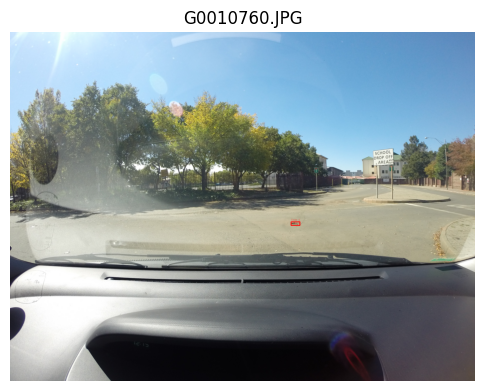

In [70]:
import os
import cv2
import random
from glob import glob
import matplotlib.pyplot as plt

# 이미지 경로 가져오기 (확장자 대소문자 구분 없이)
IMAGE_PATHS = glob("C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train2/images/*.[jJ][pP][gG]")

IMG_PATH = random.choice(IMAGE_PATHS)
LABEL_PATH = IMG_PATH.replace("images", "labels").replace(".jpg", ".txt").replace(".JPG", ".txt")

img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

if os.path.exists(LABEL_PATH):
    with open(LABEL_PATH, "r") as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 5)
            cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1)
else:
    print("라벨 파일이 존재하지 않습니다:", LABEL_PATH)

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(os.path.basename(IMG_PATH))
plt.show()


## 6. YOLO 모델 학습  
YOLO 모델을 불러와 학습을 수행하는 코드입니다.  
데이터셋 경로를 지정하고, 에포크 수 및 배치 크기를 설정하여 학습을 진행합니다.
- 기본적으로 YOLO 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장 경로를 직접 지정해야 합니다.
- `project` 및 `name` 파라미터를 사용하여 원하는 경로에 저장할 수 있습니다.

In [71]:
%matplotlib inline


In [72]:
import os
import random
from glob import glob
import cv2
import torch
from ultralytics import YOLO

DATA_YAML_PATH = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/data.yaml"
IMAGE_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images"

IMAGE_PATHS = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))
print(f"🔍 총 이미지 수: {len(IMAGE_PATHS)}")

sample_path = random.choice(IMAGE_PATHS)
sample_img = cv2.imread(sample_path)
if sample_img is None:
    raise ValueError(f"❌ 이미지 로딩 실패: {sample_path}")
else:
    print(f"✅ 샘플 이미지 로딩 성공: {sample_path}")

🔍 총 이미지 수: 25713
✅ 샘플 이미지 로딩 성공: C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images\AM_sunny_CI01_20211005_112325_449_2.jpg


In [73]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# -------------------------------
# 1. 원본 vs 리사이즈 이미지 비교 함수
# -------------------------------
def compare_original_vs_resized(image_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    img_path = random.choice(image_paths)

    orig_img = cv2.imread(img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    h, w, _ = orig_img.shape

    resized_img = cv2.resize(orig_img, (1024, 1024), interpolation=cv2.INTER_AREA)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(orig_img)
    axs[0].set_title(f"원본 이미지 ({w}x{h})")
    axs[0].axis("off")

    axs[1].imshow(resized_img)
    axs[1].set_title("리사이즈된 이미지 (640x640)")
    axs[1].axis("off")

    plt.suptitle(f"이미지: {os.path.basename(img_path)}")
    plt.tight_layout()
    plt.show()

In [74]:
# -------------------------------
# 2. 커스텀 데이터셋 클래스
# -------------------------------
class PotholeDataset(Dataset):
    def __init__(self, image_dir, target_size=(1024, 1024), transform=None):
        self.image_paths = glob(os.path.join(image_dir, "*.jpg"))
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)

        if img is None:
            print(f"이미지 로드 실패: {img_path}")
            img = np.zeros((self.target_size[0], self.target_size[1], 3), dtype=np.uint8)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, self.target_size, interpolation=cv2.INTER_AREA)

        if self.transform:
            img_resized = self.transform(img_resized)

        return img_resized, img_path

In [75]:
# -------------------------------
# 3. 시각화 함수
# -------------------------------
def show_sample_images(image_loader, num_samples=6):
    batch_data, _ = next(iter(image_loader))

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    for i, img_tensor in enumerate(batch_data[:num_samples]):
        img = img_tensor.permute(1, 2, 0).numpy()
        # 정규화 복원
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axs[i].imshow(img)
        axs[i].set_title(f"Size: {img.shape[0]}x{img.shape[1]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


In [77]:
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


model = YOLO("yolov8m.pt")

def train_model():
    results = model.train(
        data=DATA_YAML_PATH,
        epochs=150,              
        imgsz=1024,              
        batch=8,
        workers=4,
        device="0",
        conf=0.1,               
        augment=True,
        mosaic=0.8,
        project="C:/Users/제2과학과/Downloads",
        save_period = 5,
        name="pothole_yolov8m_r1champ1024(new_train)"
    )
    return results

result = train_model()

Ultralytics 8.3.123  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=C:/Users/2/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/data.yaml, epochs=150, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=5, cache=False, device=0, workers=4, project=C:/Users/2/Downloads, name=pothole_yolov8m_r1champ1024(new_train)2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.1, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sav

train: Scanning C:\Users\제2과학과\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\new_train\labels.cache... 25705 images, 0 backgrounds, 8 corrupt: 100%|██████████| 25713/25713 [00:00<?, ?it/s]

train: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\new_train\images\AM_sunny_CI02_20211020_112426_804_3.jpg: ignoring corrupt image/label: cannot identify image file 'C:\\Users\\2\\Downloads\\pothole-detection-challenge\\SSAFY_AI_CHALLENGE\\new_train\\images\\AM_sunny_CI02_20211020_112426_804_3.jpg'
train: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\new_train\images\AM_sunny_CI02_20211020_112426_806_3.jpg: ignoring corrupt image/label: cannot identify image file 'C:\\Users\\2\\Downloads\\pothole-detection-challenge\\SSAFY_AI_CHALLENGE\\new_train\\images\\AM_sunny_CI02_20211020_112426_806_3.jpg'
train: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\new_train\images\AM_sunny_CI02_20211020_112426_808_3.jpg: ignoring corrupt image/label: image file is truncated (6 bytes not processed)
train: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\new_train\images\AM_sunny_CI02_20211020_112426_809_1.jpg: ignori

val: Fast image access  (ping: 0.10.1 ms, read: 1212.6136.9 MB/s, size: 711.9 KB)


val: Scanning C:\Users\제2과학과\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\valid\labels.cache... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]

val: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\valid\images\AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\valid\images\AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file 'C:\\Users\\2\\Downloads\\pothole-detection-challenge\\SSAFY_AI_CHALLENGE\\valid\\images\\AM_sunny_CI02_20211020_112426_813_1.jpg'


Plotting labels to C:\Users\2\Downloads\pothole_yolov8m_r1champ1024(new_train)2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to C:\Users\2\Downloads\pothole_yolov8m_r1champ1024(new_train)2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      15.3G      1.426      1.528      1.218          4       1024: 100%|██████████| 3214/3214 [13:46<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:46<00:00,  8.09it/s]

                   all       5998      15797      0.661      0.523      0.601      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      8.48G      1.388      1.218      1.172          1       1024: 100%|██████████| 3214/3214 [10:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]

                   all       5998      15797      0.709      0.579      0.671      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      8.48G      1.451      1.304      1.207          2       1024: 100%|██████████| 3214/3214 [10:05<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]

                   all       5998      15797      0.698      0.568      0.654      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      8.65G       1.47      1.316      1.233          2       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]

                   all       5998      15797      0.738      0.609      0.708      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      8.47G      1.409      1.205      1.202          5       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]

                   all       5998      15797      0.757       0.64      0.741        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      8.45G      1.361      1.128      1.178          4       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]

                   all       5998      15797      0.759      0.651      0.752      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      8.49G      1.331      1.072      1.168          1       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.60it/s]

                   all       5998      15797      0.777      0.694      0.789      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      8.64G      1.301      1.013      1.148          4       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]

                   all       5998      15797      0.795      0.706      0.805      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      8.49G       1.28     0.9779      1.141         18       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]

                   all       5998      15797       0.81      0.726      0.823      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      8.48G      1.256     0.9379      1.126          1       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]

                   all       5998      15797      0.819      0.745      0.838      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      8.49G      1.246     0.9212       1.12          1       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]

                   all       5998      15797      0.821      0.753      0.847      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      8.67G      1.224     0.8915      1.113         13       1024: 100%|██████████| 3214/3214 [09:56<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]

                   all       5998      15797      0.825      0.768      0.854      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      8.49G      1.211     0.8732      1.106          2       1024: 100%|██████████| 3214/3214 [10:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]

                   all       5998      15797       0.84      0.769      0.865      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      8.47G      1.196     0.8511      1.096          0       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]

                   all       5998      15797      0.843      0.779      0.873      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      8.49G      1.184      0.835       1.09          2       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]

                   all       5998      15797      0.848      0.783      0.875      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      8.66G      1.182     0.8265      1.088          1       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]

                   all       5998      15797      0.855      0.793      0.884      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      8.49G      1.171     0.8089      1.079          1       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]

                   all       5998      15797      0.857      0.803      0.888      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      8.49G      1.166     0.8019      1.079          2       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]

                   all       5998      15797      0.859      0.807      0.895      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      8.45G      1.155     0.7868      1.077         10       1024: 100%|██████████| 3214/3214 [10:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]

                   all       5998      15797      0.858      0.815      0.898      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      8.66G      1.147     0.7737      1.068          5       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]

                   all       5998      15797      0.856      0.821      0.899      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      8.49G      1.141     0.7642      1.066         10       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]

                   all       5998      15797      0.863      0.822      0.904      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      8.46G      1.135     0.7601      1.062          2       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]

                   all       5998      15797      0.863      0.829      0.906      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      8.49G      1.123     0.7461      1.057          0       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]

                   all       5998      15797       0.87      0.827      0.908      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      8.67G      1.119     0.7424      1.058          3       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]

                   all       5998      15797      0.874      0.832      0.912      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      8.45G      1.116     0.7282      1.053          0       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]

                   all       5998      15797      0.876      0.838      0.915      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      8.44G      1.109     0.7188       1.05          1       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]

                   all       5998      15797      0.878       0.84      0.917      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      8.44G      1.105     0.7165      1.045          8       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]

                   all       5998      15797      0.877       0.84      0.918       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       8.7G        1.1     0.7107      1.043          9       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]

                   all       5998      15797      0.878      0.842       0.92      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      8.45G      1.091     0.6956      1.041          5       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]

                   all       5998      15797      0.883      0.841       0.92      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      8.46G      1.089     0.6909      1.039          4       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]

                   all       5998      15797      0.882      0.842      0.919      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      8.44G      1.086     0.6895      1.039         14       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]

                   all       5998      15797      0.882      0.844      0.921      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      8.67G      1.079     0.6829      1.038          3       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]

                   all       5998      15797      0.886      0.843      0.922      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      8.43G       1.08     0.6788      1.038          4       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.44it/s]

                   all       5998      15797      0.883      0.848      0.923      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      8.45G      1.071      0.677      1.032          5       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]

                   all       5998      15797      0.882      0.849      0.925        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      8.45G      1.068     0.6716      1.029          7       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]

                   all       5998      15797      0.882       0.85      0.926      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      8.69G      1.064     0.6631      1.028          6       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.37it/s]

                   all       5998      15797      0.886      0.848      0.926      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      8.49G      1.057     0.6565      1.026          1       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]

                   all       5998      15797      0.888      0.848      0.926      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      8.46G      1.058       0.66      1.024          1       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]

                   all       5998      15797      0.887       0.85      0.927      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      8.47G      1.054      0.652      1.023          5       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]

                   all       5998      15797      0.886      0.851      0.927      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      8.66G      1.053     0.6496      1.023          6       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]

                   all       5998      15797      0.888      0.849      0.928      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150       8.5G      1.048     0.6442      1.019          6       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]

                   all       5998      15797      0.892      0.846      0.928      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      8.46G      1.045     0.6439      1.019          4       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]

                   all       5998      15797      0.892      0.848      0.928      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      8.48G      1.045     0.6401      1.018         10       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]

                   all       5998      15797      0.891      0.849      0.929      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      8.77G      1.041     0.6392      1.018          2       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]

                   all       5998      15797       0.89      0.851      0.929      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      8.48G      1.033     0.6263      1.012          6       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]

                   all       5998      15797      0.888      0.853       0.93      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      8.44G      1.033     0.6284       1.01          2       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]

                   all       5998      15797      0.887      0.855       0.93      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      8.47G       1.03     0.6254      1.007          4       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]

                   all       5998      15797      0.886      0.857      0.931      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      8.69G      1.024     0.6178      1.009          2       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]

                   all       5998      15797      0.892      0.852      0.931       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      8.55G      1.026     0.6183       1.01          6       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]

                   all       5998      15797      0.891      0.855      0.931       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      8.44G      1.021     0.6094      1.008          2       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.37it/s]

                   all       5998      15797      0.889      0.856      0.931      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      8.44G      1.021     0.6097      1.007          6       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]

                   all       5998      15797      0.889      0.857      0.931      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      8.64G      1.013      0.606      1.003          3       1024: 100%|██████████| 3214/3214 [10:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]

                   all       5998      15797      0.893      0.856      0.932      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      8.45G      1.016     0.6048      1.002          2       1024: 100%|██████████| 3214/3214 [11:21<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]

                   all       5998      15797      0.893      0.857      0.932      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      8.45G      1.013     0.6022      1.003          9       1024: 100%|██████████| 3214/3214 [11:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]

                   all       5998      15797      0.895      0.856      0.933      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      8.46G      1.008     0.5955      1.001          1       1024: 100%|██████████| 3214/3214 [11:05<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]

                   all       5998      15797      0.893      0.857      0.933      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      8.68G      1.004     0.5921     0.9983          2       1024: 100%|██████████| 3214/3214 [10:07<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]

                   all       5998      15797      0.894      0.858      0.933      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150       8.5G      1.002     0.5905      0.998         10       1024: 100%|██████████| 3214/3214 [10:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]

                   all       5998      15797      0.895      0.858      0.934      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      8.48G      1.001     0.5893     0.9955          4       1024: 100%|██████████| 3214/3214 [10:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]

                   all       5998      15797      0.894      0.859      0.934      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      8.48G     0.9984     0.5866     0.9971          3       1024: 100%|██████████| 3214/3214 [10:02<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]

                   all       5998      15797      0.895      0.859      0.934      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      8.66G     0.9911     0.5811     0.9933          4       1024: 100%|██████████| 3214/3214 [10:02<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]

                   all       5998      15797      0.897      0.858      0.934      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      8.47G     0.9967     0.5809     0.9944          0       1024: 100%|██████████| 3214/3214 [10:01<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]

                   all       5998      15797      0.897      0.859      0.935      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      8.46G     0.9961     0.5841     0.9946          2       1024: 100%|██████████| 3214/3214 [10:22<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]

                   all       5998      15797      0.896      0.861      0.935      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      8.48G     0.9884     0.5778     0.9894          2       1024: 100%|██████████| 3214/3214 [10:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]

                   all       5998      15797      0.899      0.859      0.935      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      8.64G     0.9831     0.5753     0.9909          0       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]

                   all       5998      15797      0.897       0.86      0.935      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      8.49G     0.9893     0.5735      0.991          1       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]

                   all       5998      15797      0.897      0.861      0.935      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      8.49G     0.9812     0.5693     0.9869          2       1024: 100%|██████████| 3214/3214 [10:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.22it/s]

                   all       5998      15797      0.896      0.863      0.936      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      8.46G     0.9803     0.5683     0.9884          7       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]

                   all       5998      15797      0.898      0.862      0.936      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      8.64G     0.9799     0.5663     0.9872          4       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]

                   all       5998      15797      0.898      0.863      0.936      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      8.49G     0.9734     0.5609     0.9849          3       1024: 100%|██████████| 3214/3214 [10:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]

                   all       5998      15797      0.897      0.865      0.937      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      8.45G     0.9732     0.5608     0.9852          2       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]

                   all       5998      15797      0.897      0.865      0.937      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      8.48G     0.9684      0.561     0.9828          0       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]

                   all       5998      15797      0.898      0.865      0.937      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      8.65G     0.9705     0.5588     0.9816          4       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]

                   all       5998      15797      0.898      0.866      0.937       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      8.44G     0.9683     0.5531     0.9855          1       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]

                   all       5998      15797      0.899      0.865      0.937       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      8.45G     0.9622     0.5492     0.9809          9       1024: 100%|██████████| 3214/3214 [10:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]

                   all       5998      15797      0.899      0.866      0.937       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      8.47G     0.9597     0.5488      0.976          3       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]

                   all       5998      15797        0.9      0.866      0.938      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      8.66G     0.9568     0.5479     0.9789          1       1024: 100%|██████████| 3214/3214 [10:05<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]

                   all       5998      15797        0.9      0.866      0.938      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      8.49G     0.9574     0.5437     0.9765          0       1024: 100%|██████████| 3214/3214 [10:07<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]

                   all       5998      15797      0.901      0.867      0.938      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150       8.5G     0.9518     0.5396     0.9764          7       1024: 100%|██████████| 3214/3214 [10:38<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.59it/s]

                   all       5998      15797      0.902      0.867      0.939      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      8.45G     0.9527     0.5378     0.9752          2       1024: 100%|██████████| 3214/3214 [10:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]

                   all       5998      15797        0.9      0.868      0.939      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       8.7G     0.9539     0.5392     0.9721          2       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]

                   all       5998      15797      0.902      0.867      0.939      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      8.51G     0.9497     0.5359     0.9744          7       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]

                   all       5998      15797      0.899       0.87      0.939      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      8.44G     0.9457     0.5314     0.9734          4       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]

                   all       5998      15797      0.901       0.87       0.94      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      8.45G     0.9425     0.5304      0.972          3       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]

                   all       5998      15797      0.902      0.869       0.94      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      8.69G     0.9396     0.5265     0.9679          3       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]

                   all       5998      15797      0.904      0.868       0.94      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      8.42G     0.9353     0.5236     0.9678          4       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.37it/s]

                   all       5998      15797      0.904      0.868       0.94      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      8.45G     0.9351      0.524     0.9669          1       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


                   all       5998      15797      0.904      0.869       0.94      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      8.45G     0.9334      0.521      0.966          2       1024: 100%|██████████| 3214/3214 [10:33<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.36it/s]

                   all       5998      15797      0.901      0.871       0.94      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      8.67G     0.9322     0.5185     0.9634          4       1024: 100%|██████████| 3214/3214 [10:41<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.64it/s]

                   all       5998      15797      0.902      0.872      0.941      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      8.45G     0.9272     0.5156     0.9617          1       1024: 100%|██████████| 3214/3214 [10:44<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:45<00:00,  8.24it/s]

                   all       5998      15797        0.9      0.875       0.94      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      8.51G      0.923     0.5135      0.958          2       1024: 100%|██████████| 3214/3214 [10:40<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.57it/s]

                   all       5998      15797      0.901      0.875      0.941      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      8.46G     0.9227     0.5125     0.9615          8       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.56it/s]

                   all       5998      15797      0.902      0.874      0.941      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      8.67G     0.9236     0.5115     0.9615         10       1024: 100%|██████████| 3214/3214 [10:37<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]

                   all       5998      15797      0.902      0.874      0.941      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      8.47G     0.9201     0.5067     0.9628          3       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.48it/s]

                   all       5998      15797      0.903      0.873      0.941      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      8.46G     0.9163     0.5031     0.9573          1       1024: 100%|██████████| 3214/3214 [10:35<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]

                   all       5998      15797      0.904      0.874      0.942      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       8.5G     0.9099     0.5021     0.9583          2       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]

                   all       5998      15797      0.904      0.874      0.942      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      8.69G     0.9075      0.501     0.9561          5       1024: 100%|██████████| 3214/3214 [10:37<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]

                   all       5998      15797      0.904      0.875      0.942      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      8.43G     0.9089     0.4981     0.9546          9       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]

                   all       5998      15797      0.905      0.875      0.942      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      8.49G     0.9038     0.4954     0.9539          5       1024: 100%|██████████| 3214/3214 [10:34<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.61it/s]

                   all       5998      15797      0.906      0.874      0.942      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      8.48G     0.9049     0.4944     0.9533          2       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.53it/s]

                   all       5998      15797      0.903      0.878      0.942      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      8.76G     0.8984     0.4896     0.9501          3       1024: 100%|██████████| 3214/3214 [10:37<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.57it/s]

                   all       5998      15797      0.908      0.875      0.942      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      8.48G     0.8987     0.4904      0.952         19       1024: 100%|██████████| 3214/3214 [10:39<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.56it/s]

                   all       5998      15797      0.906      0.877      0.942      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      8.47G     0.8969     0.4851     0.9518          6       1024: 100%|██████████| 3214/3214 [10:37<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.48it/s]

                   all       5998      15797      0.906      0.877      0.942      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      8.55G     0.8954     0.4817     0.9481          3       1024: 100%|██████████| 3214/3214 [10:06<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:42<00:00,  8.93it/s]

                   all       5998      15797      0.906      0.877      0.942      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      8.76G     0.8895     0.4799     0.9467          5       1024: 100%|██████████| 3214/3214 [10:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]

                   all       5998      15797      0.903       0.88      0.942       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      8.48G     0.8839     0.4746     0.9446          2       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]

                   all       5998      15797      0.904       0.88      0.942       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      8.49G     0.8851      0.475     0.9443          1       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.45it/s]

                   all       5998      15797      0.902      0.883      0.942       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      8.48G     0.8807     0.4709     0.9412          5       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]

                   all       5998      15797      0.903      0.883      0.942       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      8.69G      0.879     0.4713     0.9399          1       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]

                   all       5998      15797      0.902      0.885      0.943       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      8.45G     0.8726     0.4657     0.9405          3       1024: 100%|██████████| 3214/3214 [10:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]

                   all       5998      15797      0.901      0.885      0.943       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      8.44G     0.8679     0.4633     0.9366          3       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]

                   all       5998      15797        0.9      0.887      0.943       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      8.44G     0.8659      0.461     0.9347          6       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]

                   all       5998      15797      0.901      0.887      0.943       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      8.66G     0.8671     0.4615     0.9361          1       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]

                   all       5998      15797      0.901      0.886      0.943       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      8.46G     0.8629     0.4573     0.9364          4       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]

                   all       5998      15797      0.901      0.887      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      8.43G      0.857     0.4516     0.9345          1       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]

                   all       5998      15797        0.9      0.888      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      8.49G     0.8565     0.4524     0.9348          5       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]

                   all       5998      15797      0.902      0.886      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      8.67G     0.8549      0.451     0.9335          0       1024: 100%|██████████| 3214/3214 [09:58<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]

                   all       5998      15797      0.901      0.887      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      8.48G     0.8491     0.4467     0.9311          1       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]

                   all       5998      15797      0.902      0.887      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150       8.5G     0.8448     0.4414      0.931          2       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]

                   all       5998      15797      0.903      0.887      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      8.43G      0.846     0.4422      0.931          1       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]

                   all       5998      15797      0.904      0.886      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      8.66G     0.8381     0.4413     0.9306          1       1024: 100%|██████████| 3214/3214 [09:57<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]

                   all       5998      15797      0.904      0.886      0.943      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      8.47G     0.8344     0.4363     0.9284         11       1024: 100%|██████████| 3214/3214 [10:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]

                   all       5998      15797      0.902      0.888      0.943      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      8.49G     0.8335      0.433      0.927          1       1024: 100%|██████████| 3214/3214 [10:13<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]

                   all       5998      15797      0.902      0.889      0.943      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       8.5G     0.8321     0.4345     0.9256          3       1024: 100%|██████████| 3214/3214 [09:59<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]

                   all       5998      15797      0.901       0.89      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      8.65G     0.8254      0.427      0.922          6       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]

                   all       5998      15797      0.903      0.889      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      8.46G     0.8227      0.423     0.9207          1       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]

                   all       5998      15797      0.903      0.888      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      8.44G     0.8176     0.4229     0.9205          4       1024: 100%|██████████| 3214/3214 [10:35<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]

                   all       5998      15797      0.903      0.889      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      8.46G     0.8162     0.4185     0.9214         11       1024: 100%|██████████| 3214/3214 [10:31<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]

                   all       5998      15797      0.904      0.889      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      8.69G     0.8183     0.4201     0.9233          1       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]

                   all       5998      15797      0.903      0.889      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150       8.5G     0.8092     0.4139     0.9177          3       1024: 100%|██████████| 3214/3214 [10:35<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.48it/s]

                   all       5998      15797      0.903       0.89      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      8.45G     0.8093     0.4132      0.917          3       1024: 100%|██████████| 3214/3214 [10:34<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]

                   all       5998      15797      0.903       0.89      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      8.46G     0.8034     0.4122     0.9159          8       1024: 100%|██████████| 3214/3214 [10:35<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]

                   all       5998      15797      0.902      0.892      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      8.67G     0.8001     0.4063     0.9139          4       1024: 100%|██████████| 3214/3214 [10:33<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.57it/s]

                   all       5998      15797      0.903      0.892      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      8.48G     0.7958     0.4035     0.9155          2       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]

                   all       5998      15797      0.904      0.891      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      8.47G     0.7914     0.4017     0.9121          2       1024: 100%|██████████| 3214/3214 [10:35<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.43it/s]

                   all       5998      15797      0.904      0.892      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      8.43G     0.7893     0.4014     0.9133          3       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.54it/s]

                   all       5998      15797      0.905      0.891      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      8.64G     0.7834     0.3968     0.9089          7       1024: 100%|██████████| 3214/3214 [10:35<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]

                   all       5998      15797      0.906      0.891      0.943      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      8.45G     0.7815     0.3943     0.9092          1       1024: 100%|██████████| 3214/3214 [10:33<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]

                   all       5998      15797      0.906      0.889      0.942      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      8.43G     0.7791      0.393     0.9077          1       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]

                   all       5998      15797      0.905      0.891      0.943      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      8.46G     0.7743     0.3888     0.9051          4       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.42it/s]

                   all       5998      15797      0.906      0.891      0.943      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      8.66G     0.7726      0.386     0.9041          2       1024: 100%|██████████| 3214/3214 [10:36<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]

                   all       5998      15797      0.907      0.891      0.943      0.733


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      8.45G     0.7406     0.3557     0.8945          2       1024: 100%|██████████| 3214/3214 [10:30<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]

                   all       5998      15797      0.908       0.89      0.942      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      8.44G     0.7336     0.3507     0.8914          1       1024: 100%|██████████| 3214/3214 [10:31<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.62it/s]

                   all       5998      15797      0.908       0.89      0.942      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      8.47G     0.7289     0.3478     0.8931          1       1024: 100%|██████████| 3214/3214 [10:30<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [00:43<00:00,  8.53it/s]

                   all       5998      15797      0.908       0.89      0.942      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      8.62G     0.7217     0.3447     0.8895         29       1024:  71%|███████▏  | 2298/3214 [07:33<03:00,  5.07it/s]


KeyboardInterrupt: 

## 7. 학습 결과 시각화

YOLO 모델 학습 과정에서 저장된 손실 그래프(`results.png`)를 불러와 시각화하는 코드입니다.  
`matplotlib`을 사용하여 이미지를 출력하고, 그래프 외 요소는 제거하여 깔끔하게 보여줍니다.

- 기본적으로 학습 결과는 `runs/detect/train` 디렉토리에 저장됩니다.  
- 캐글 환경에서는 저장된 경로를 명시적으로 지정해주어야 합니다.


In [ ]:
TRAIN_RUN_DIR = "C:/Users/제2과학과/Downloads/pothole_yolov8m_r1champ1024(new_train)2"
loss_plot_path = f"{TRAIN_RUN_DIR}/results.png"

img = plt.imread(loss_plot_path)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Training Loss Graph")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/제2과학과/Downloads/pothole_yolov8m_r1champ1024/results.png'

In [44]:
import os
from glob import glob

# 이미지와 라벨 디렉토리 경로 설정
IMG_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/images"
LABEL_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/new_train/labels"

# 이미지 파일 목록 가져오기 (확장자 대소문자 구분 없이)
image_paths = glob(os.path.join(IMG_DIR, "*.[jJ][pP][gG]"))
print(f"🔍 전체 이미지 수: {len(image_paths)}장")

deleted_count = 0

for img_path in image_paths:
    basename = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(LABEL_DIR, basename + ".txt")

    if not os.path.exists(label_path):
        print(f"라벨 없음 → 삭제: {img_path}")
        os.remove(img_path)
        deleted_count += 1

print(f"\n✅ 삭제된 이미지 수: {deleted_count}장")
print(f"✅ 남은 이미지 수: {len(image_paths) - deleted_count}장")


🔍 전체 이미지 수: 25713장

✅ 삭제된 이미지 수: 0장
✅ 남은 이미지 수: 25713장


In [41]:
import os
from glob import glob

IMG_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/train2/images" 
image_paths = glob(os.path.join(IMG_DIR, "*.[jJ][pP][gG]"))

seen = set()
deleted_count = 0

for path in image_paths:
    name = os.path.splitext(os.path.basename(path))[0].lower()
    if name in seen:
        print(f"📛 중복 이름 → 삭제: {path}")
        os.remove(path)
        deleted_count += 1
    else:
        seen.add(name)

print(f"\n✅ 이름 기준 삭제된 이미지 수: {deleted_count}장")



✅ 이름 기준 삭제된 이미지 수: 0장


## 8. 모델 성능 평가  
학습된 YOLO 모델을 불러와 검증 데이터셋을 이용해 성능을 평가하는 코드입니다.  
`val()` 함수를 사용하여 `mAP`, `Precision`, `Recall` 등의 성능 지표를 계산합니다.

- 캐글 환경에서는 모델이 저장된 경로를 지정해줘야 합니다.


In [ ]:
model = YOLO("C:/Users/제2과학과/Downloads/pothole_yolov8m_r1champ1024(new_train)2/weights/epoch130.pt")

val_results = model.val(data=DATA_YAML_PATH, split="val")

print("검증 데이터 평가 결과:")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")

Ultralytics 8.3.123  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3651.9973.4 MB/s, size: 721.5 KB)


val: Scanning C:\Users\제2과학과\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\valid\labels.cache... 5998 images, 0 backgrounds, 2 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]

val: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\valid\images\AM_sunny_CI02_20211020_112426_809_2.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\valid\images\AM_sunny_CI02_20211020_112426_813_1.jpg: ignoring corrupt image/label: cannot identify image file 'C:\\Users\\2\\Downloads\\pothole-detection-challenge\\SSAFY_AI_CHALLENGE\\valid\\images\\AM_sunny_CI02_20211020_112426_813_1.jpg'



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 375/375 [01:03<00:00,  5.92it/s]


                   all       5998      15797      0.912      0.884      0.946      0.717
Speed: 0.2ms preprocess, 7.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\val8
검증 데이터 평가 결과:
mAP50: 0.9463
mAP50-95: 0.7168
Precision: 0.9119
Recall: 0.8843


## 9. 모델 추론 및 시각화
학습된 YOLO 모델을 사용하여 테스트 데이터셋에서 임의의 이미지를 추론합니다.

- 포트홀을 감지하지 못하면 아무것도 표시되지 않습니다.


image 1/1 C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\test\images\AM_sunny_CI03_20211028_110955_659_1.jpg: 384x640 1 pothole, 40.3ms
Speed: 4.1ms preprocess, 40.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


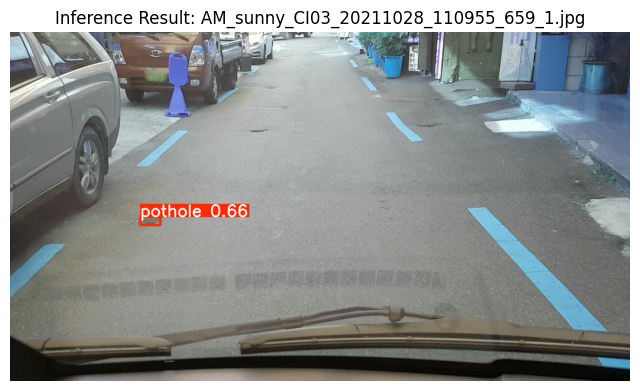

In [ ]:
model = YOLO("C:/Users/제2과학과/Downloads/pothole_yolov8m_r1champ1024(new_train)2/weights/epoch130.pt")

TEST_IMAGE_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")))
test_img_path = random.choice(test_image_paths)

results = model.predict(source=test_img_path, conf=0.25, imgsz=640, save=False)

result_img = results[0].plot()

plt.figure(figsize=(8, 6))
plt.imshow(result_img)
plt.axis("off")
plt.title(f"Inference Result: {os.path.basename(test_img_path)}")
plt.show()

In [84]:
import pandas as pd

results_csv_path = "C:/Users/제2과학과/Downloads/pothole_yolov8m_r1champ1024(new_train)2/results.csv"

# CSV 읽기
df = pd.read_csv(results_csv_path)

# 가장 높은 mAP50-95를 가진 row 찾기
best_epoch = df["metrics/mAP50-95(B)"].idxmax()

print(f"📌 best.pt는 epoch {best_epoch}에서 저장되었습니다.")


📌 best.pt는 epoch 129에서 저장되었습니다.


## 10. 제출 파일 생성 (submission.csv)
테스트 이미지에 대해 학습된 YOLO 모델을 사용하여 객체 탐지를 수행하고,  
예측 결과를 제출 형식에 맞춰 `submission.csv` 파일로 저장합니다.

- 한 이미지당 박스 하나만 제출하며, confidence가 가장 높은 박스를 사용합니다.
- 객체를 감지하지 못한 경우, `ClassId`와 바운딩 박스 좌표는 모두 0으로 처리합니다.
- 이미지가 손상되었거나 열리지 않는 경우에도 에러 없이 넘어가도록 예외 처리를 포함합니다.
- Output 경로인 /kagggle/working/에 저장됩니다.

In [ ]:
import pandas as pd

model = YOLO("C:/Users/제2과학과/Downloads/pothole_yolov8m_r1champ1024(new_train)2/weights/epoch130.pt")

TEST_IMAGE_DIR = "C:/Users/제2과학과/Downloads/pothole-detection-challenge/SSAFY_AI_CHALLENGE/test/images"
test_image_paths = sorted(glob(os.path.join(TEST_IMAGE_DIR, "*.jpg")))

submission_rows = []

for img_path in test_image_paths:
    image_id = os.path.basename(img_path)

    if cv2.imread(img_path) is None:
        print(f"이미지 로드 실패: {image_id}")
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })
        continue

    results = model.predict(source=img_path, conf=0.01, imgsz=1024, augment=True, save=False)
    result = results[0]

    if len(result.boxes) > 0:
        boxes = result.boxes
        best_idx = boxes.conf.argmax().item()
        cls_id = int(boxes.cls[best_idx].item())
        cx, cy, w, h = boxes.xywhn[best_idx].tolist()

        submission_rows.append({
            "ImageId": image_id,
            "ClassId": cls_id,
            "X": round(cx, 6),
            "Y": round(cy, 6),
            "Width": round(w, 6),
            "Height": round(h, 6),
        })
    else:
        submission_rows.append({
            "ImageId": image_id,
            "ClassId": 0,
            "X": 0,
            "Y": 0,
            "Width": 0,
            "Height": 0,
        })

submission_df = pd.DataFrame(submission_rows, columns=["ImageId", "ClassId", "X", "Y", "Width", "Height"])
submission_path = "C:/Users/제2과학과/Downloads/submission986.csv"
submission_df.to_csv(submission_path, index=False)
print(f"제출 파일 저장 완료: {submission_path}")


image 1/1 C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\test\images\AM_sunny_CI01_20210916_105931_11_117_2.jpg: 576x1024 5 potholes, 164.5ms
Speed: 4.1ms preprocess, 164.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\test\images\AM_sunny_CI01_20210916_105931_11_118_2.jpg: 576x1024 2 potholes, 23.1ms
Speed: 3.9ms preprocess, 23.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\test\images\AM_sunny_CI01_20210916_105931_11_134_1.jpg: 576x1024 6 potholes, 23.2ms
Speed: 3.1ms preprocess, 23.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 C:\Users\2\Downloads\pothole-detection-challenge\SSAFY_AI_CHALLENGE\test\images\AM_sunny_CI01_20210916_105931_11_137_2.jpg: 576x1024 1 pothole, 20.1ms
Speed: 3.3ms preprocess, 20.1ms inference, 1.0ms post